In [37]:
# Sources:
# - CA Secretary of State – Official Voter Guide, Prop 1 hub (title/summary, what your vote means, links to text of law)
#   https://vigarchive.sos.ca.gov/2024/primary/propositions/1/
# - Official Title & Summary (Attorney General) + LAO fiscal estimate
#   https://vigarchive.sos.ca.gov/2024/primary/propositions/1/title-summary.htm
# - Legislative Analyst’s Office overview (plain-language explainer)
#   https://lao.ca.gov/BallotAnalysis/Proposition?number=1&year=2024
# - Ballotpedia summary page for context
#   https://ballotpedia.org/California_Proposition_1%2C_Behavioral_Health_Services_Program_and_Bond_Measure_%28March_2024%29

ballot = """STATE OF CALIFORNIA — PROPOSITION 1 (March 5, 2024)
Behavioral Health Services Program and Bond Measure

OVERVIEW
The Legislature placed this measure on the ballot to update California’s behavioral health system and finance new facilities and housing. It would authorize about $6.38 billion in state general obligation bonds to help build or expand: (1) mental health and substance use treatment facilities and (2) housing and supportive services for people who are homeless or at risk of homelessness and living with behavioral health challenges. The measure also revises the Mental Health Services Act to broaden eligible uses (including substance use disorder services), adjust funding allocations, and add oversight/audit provisions. (AB 531 & SB 326, 2023.)

WHAT YOUR VOTE MEANS (paraphrased)
YES — Counties would shift some behavioral health spending toward housing and personalized supports, and the state could borrow up to $6.4B to add treatment capacity and housing for people with mental health or substance use conditions.
NO — Counties would keep current program emphasis and the state would not issue the new bonds for treatment facilities or housing.

FISCAL EFFECTS (high level)
• Ongoing state bond repayment costs of roughly a few hundred million dollars per year over several decades, depending on issuance and interest.
• Shifts roughly a portion of existing statewide behavioral health tax revenue from counties to state-directed priorities, with programmatic trade-offs.

KEY ELEMENTS
• Bond Authority: Approximately $6.38 billion in state general obligation bonds for facility construction, modernization, and housing tied to behavioral health needs (including dedicated funds for homeless veterans).
• Program Reforms: Updates the Mental Health Services Act to allow funding for substance use disorder treatment in addition to mental health treatment; recalibrates spending categories (e.g., full-service partnerships, early intervention and other services, and housing-related supports); requires regular reporting and audits.
• Populations Served: People with serious mental illness or substance use disorders, including individuals experiencing homelessness or at risk of homelessness; includes veteran-specific housing/support components.

BALLOT LABEL (paraphrased from Official Title & Summary)
Authorizes multi-billion-dollar bonds for mental health and substance use treatment facilities; provides housing/supportive services for individuals experiencing homelessness with behavioral health needs; revises statewide mental health funding rules and oversight; legislative statute.

LEGISLATIVE HISTORY / PLACEMENT
Referred to voters by the California Legislature through AB 531 (Ch. 789, 2023) and SB 326 (Ch. 790, 2023) for the March 5, 2024, statewide election.
"""

In [38]:
"""
Ballot Measure Summarization Workflow

This workflow takes a ballot measure text and:
1. Summarizes it in plain language (300 words)
2. Identifies key stakeholders using structured JSON output
3. Creates a moderated network of stakeholder agents to provide interactive perspectives
"""

import json
import random
from typing import Dict, List, Any, Tuple
from litellm import completion
from plurals.agent import Agent
from plurals.deliberation import Graph, Moderator
from dotenv import load_dotenv

load_dotenv("../src/.env")

def summarize_ballot_measure(ballot_text: str, model: str = "gpt-4o-mini") -> str:
    """
    Step 1: Summarize the ballot measure in plain language

    Args:
        ballot_text: The full text of the ballot measure
        model: LLM model to use

    Returns:
        Plain language summary in ~300 words
    """

    prompt = f"""
    Please summarize the following ballot measure in plain, accessible language that any voter could understand.
    Focus on:
    - What the measure would actually do
    - Who would be affected
    - Key arguments for and against

    Limit your response to approximately 300 words.

    BALLOT MEASURE TEXT:
    {ballot_text}
    """

    response = completion(
        model=model,
        messages=[{"role": "user", "content": prompt}]
    )
    print(response.choices[0].message.content)
    return response.choices[0].message.content

summary_text = summarize_ballot_measure(ballot)

**Summary of California Proposition 1**

**What the Measure Would Do:**  
Proposition 1 seeks to improve California's behavioral health system by authorizing approximately $6.38 billion in state bonds. This funding would be used to build and upgrade mental health and substance use treatment facilities and to create housing and supportive services for people who are homeless or at risk of homelessness due to behavioral health issues. Additionally, it reforms the existing Mental Health Services Act to include services for substance use disorders, adjust funding allocations, and implement greater oversight.

**Who Would Be Affected:**  
The measure primarily targets individuals with serious mental illnesses or substance use disorders, especially those who are homeless or facing homelessness. It also includes provisions specifically for veterans, ensuring they receive the necessary housing and support.

**Key Arguments For and Against:**

*For:*  
- Supporters argue that the measure addres

In [39]:
# --- Stakeholders + Neutral (Notebook Cell) ----------------------------------
import json
from typing import Dict, List
from dotenv import load_dotenv
from litellm import completion

# Your existing Agent class
from plurals.agent import Agent

# Load env (API keys, etc.)
load_dotenv()

def identify_stakeholders(ballot_text: str, model: str = "gpt-4o") -> Dict[str, List[str]]:
    """
    Identify the top stakeholders for/against the measure using structured JSON.
    Returns exactly 3 supporters and 3 opponents.
    """
    prompt = f"""
    Analyze the ballot measure below and return ONLY valid JSON with exactly:
    {{
      "primary_supporters": ["<specific group>", "<specific group>", "<specific group>"],
      "primary_opponents":  ["<specific group>", "<specific group>", "<specific group>"]
    }}

    Rules:
    - Exactly 3 per side. No explanations or extra keys.
    - Use realistic stakeholder groups relevant to Hawaii's judicial/legislative context
      (e.g., bar associations, civil liberties orgs, taxpayer watchdogs, good-government groups,
       judiciary administration, legislative leadership groups, etc.).

    BALLOT MEASURE TEXT:
    {ballot_text}
    """

    resp = completion(
        model=model,
        messages=[{"role": "user", "content": prompt}],
        response_format={"type": "json_object"},
        temperature=0.2,
    )

    try:
        data = json.loads(resp.choices[0].message.content)
    except Exception as e:
        raise ValueError(f"Failed to parse stakeholder JSON: {e}\nRaw: {resp.choices[0].message.content}")

    supporters = list(dict.fromkeys(data.get("primary_supporters", [])))[:3]
    opponents  = list(dict.fromkeys(data.get("primary_opponents",  [])))[:3]

    # Pad if the model under-returns (rare, but keeps notebook robust)
    while len(supporters) < 3:
        supporters.append(f"Supporter Placeholder {len(supporters)+1}")
    while len(opponents) < 3:
        opponents.append(f"Opponent Placeholder {len(opponents)+1}")

    return {
        "primary_supporters": supporters[:3],
        "primary_opponents":  opponents[:3],
    }

def create_stakeholder_agents_with_neutral(
    stakeholders: Dict[str, List[str]],
    model: str = "gpt-4o",
    temp_support: float = 0.7,
    temp_oppose: float = 0.7,
    temp_neutral: float = 0.3,
    include_neutral: bool = True,
) -> List[Agent]:
    """
    Build stance-aware personas from stakeholder lists and append a Neutral Voter at the end.
    """
    agents: List[Agent] = []

    for g in stakeholders.get("primary_supporters", []):
        agents.append(Agent(
            persona=(
                f"You represent {g}. You SUPPORT the measure. "
                "Acknowledge exactly one prior point by name, state your stance clearly, "
                "address one counterpoint, and add one concrete consideration supporters care about."
            ),
            model=model,
            kwargs={"temperature": temp_support},
        ))

    for g in stakeholders.get("primary_opponents", []):
        agents.append(Agent(
            persona=(
                f"You represent {g}. You OPPOSE the measure. "
                "Acknowledge exactly one prior point by name, state your stance clearly, "
                "address one counterpoint, and add one concrete consideration opponents care about."
            ),
            model=model,
            kwargs={"temperature": temp_oppose},
        ))

    if include_neutral:
        agents.append(Agent(
            persona=(
                "You are a NEUTRAL voter. Before reading others, record pre_lean (Likert -3..+3). "
                "After the discussion, record post_lean (Likert -3..+3) and confidence (0–100). "
                "Also output: top_driver ('Support'|'Oppose'), counterweight ('Oppose'|'Support'), and unknowns[]. "
                "Weigh both sides fairly and cite one point per side where possible."
            ),
            model=model,
            kwargs={"temperature": temp_neutral},
        ))

    return agents

# --- Run this block to produce stakeholders and agents -----------------------
MODEL = "gpt-4o"  # or your preferred route via LiteLLM

stakeholders = identify_stakeholders(ballot, model=MODEL)
agents = create_stakeholder_agents_with_neutral(stakeholders, model=MODEL, include_neutral=True)

print("Stakeholders:", json.dumps(stakeholders, indent=2))
print(f"Total agents (support+oppose+neutral): {len(agents)}")
# The NEUTRAL voter is the last agent in the list by construction.

Stakeholders: {
  "primary_supporters": [
    "California Psychiatric Association",
    "Mental Health America of California",
    "California State Association of Counties"
  ],
  "primary_opponents": [
    "California Taxpayers Association",
    "Howard Jarvis Taxpayers Association",
    "California Chamber of Commerce"
  ]
}
Total agents (support+oppose+neutral): 7


In [40]:
# === Five DAG networks (cycle-safe) ==========================================
from typing import List, Tuple, Dict, Any
from copy import deepcopy
from plurals.agent import Agent

Edge = Tuple[int, int]  # (from_idx, to_idx)

# ---- helpers ----------------------------------------------------------------
def _infer_stance_indices(agents: List[Agent]) -> Dict[str, List[int]]:
    sup, opp, neu = [], [], []
    for i, a in enumerate(agents):
        p = (getattr(a, "persona", "") or "").lower()
        if "support the measure" in p:
            sup.append(i)
        elif "oppose the measure" in p:
            opp.append(i)
        elif "neutral voter" in p:
            neu.append(i)
    return {"support": sup, "oppose": opp, "neutral": neu}

def _get_neutral_idx(agents: List[Agent]) -> int:
    idx = _infer_stance_indices(agents)
    if idx["neutral"]:
        return idx["neutral"][-1]  # assume last neutral if multiple
    return len(agents) - 1        # fallback: last agent

# ---- 1) Star Sink Townhall (neutral as sink) --------------------------------
def build_star_townhall(agents: List[Agent]) -> Tuple[List[Edge], Dict[str, Any]]:
    neutral_idx = _get_neutral_idx(agents)
    edges = [(i, neutral_idx) for i in range(len(agents)) if i != neutral_idx]
    meta = {"name": "star_townhall", "neutral_idx": neutral_idx, "neutral_pre_post": "post"}
    return edges, meta

# ---- 2) Cross-Exam Chain (alternating S/O, neutral ONLY as sink) ------------
def build_cross_exam_chain(agents: List[Agent]) -> Tuple[List[Edge], Dict[str, Any]]:
    """
    Alternating S, O, S, O, ... in a linear chain; the chain then feeds into NEUTRAL.
    No edge originates from neutral, so the graph remains a DAG.
    """
    idx = _infer_stance_indices(agents)
    S, O = idx["support"], idx["oppose"]
    neutral_idx = _get_neutral_idx(agents)

    # Build alternating sequence S, O, S, O ...
    thread: List[int] = []
    L = min(len(S), len(O))
    for k in range(L):
        thread.extend([S[k], O[k]])
    if len(S) > L:
        thread.append(S[L])
    if len(O) > L:
        thread.append(O[L])

    # If no advocates, just return an empty chain (no edges)
    if not thread:
        edges: List[Edge] = []
    else:
        # Linear chain among advocates
        edges = [(thread[i], thread[i+1]) for i in range(len(thread)-1)]
        # Final hop into neutral (neutral is sink)
        edges.append((thread[-1], neutral_idx))

    meta = {
        "name": "cross_exam_chain",
        "neutral_idx": neutral_idx,
        "order": "alternating_chain→neutral",
        "neutral_pre_post": "post"
    }
    return edges, meta

# ---- 3) Two-batch (support-first) feeding into neutral ----------------------
def build_two_batch_support_first(agents: List[Agent]) -> Tuple[List[Edge], Dict[str, Any]]:
    idx = _infer_stance_indices(agents)
    S, O = idx["support"], idx["oppose"]
    neutral_idx = _get_neutral_idx(agents)
    # All supporters -> neutral, then all opponents -> neutral (still a DAG: all edges point to sink)
    edges = [(i, neutral_idx) for i in S] + [(j, neutral_idx) for j in O]
    meta = {"name": "two_batch_support_first", "neutral_idx": neutral_idx, "order": {"support_then_oppose": [S, O]}, "neutral_pre_post": "post"}
    return edges, meta

# ---- 4) Two-batch (oppose-first) feeding into neutral -----------------------
def build_two_batch_oppose_first(agents: List[Agent]) -> Tuple[List[Edge], Dict[str, Any]]:
    idx = _infer_stance_indices(agents)
    S, O = idx["support"], idx["oppose"]
    neutral_idx = _get_neutral_idx(agents)
    edges = [(j, neutral_idx) for j in O] + [(i, neutral_idx) for i in S]
    meta = {"name": "two_batch_oppose_first", "neutral_idx": neutral_idx, "order": {"oppose_then_support": [O, S]}, "neutral_pre_post": "post"}
    return edges, meta

# ---- 5) Evidence layer -> advocates -> neutral ------------------------------
def build_evidence_to_neutral(agents: List[Agent]) -> Tuple[List[Edge], Dict[str, Any], List[Agent]]:
    """
    Adds a lightweight 'evidence' node before each advocate:
      Evidence_i -> Advocate_i, then Advocate_i -> Neutral.
    All edges point forward to neutral (sink), so it's a DAG.
    """
    idx = _infer_stance_indices(agents)
    advocates = idx["support"] + idx["oppose"]
    neutral_idx = _get_neutral_idx(agents)

    new_agents = deepcopy(agents)
    evidence_idxs: List[int] = []

    for a_idx in advocates:
        ev = Agent(
            persona=("You are an EVIDENCE node. Provide a concrete data point or precedent "
                     "the connected advocate can cite. Keep it to two sentences."),
            model=new_agents[a_idx].model,
            kwargs={'temperature': 0.2}
        )
        try: ev.name = "Evidence"
        except Exception: pass
        new_agents.append(ev)
        evidence_idxs.append(len(new_agents) - 1)

    e2a = [(e, a) for e, a in zip(evidence_idxs, advocates)]
    a2n = [(a, neutral_idx) for a in advocates]
    edges = e2a + a2n

    meta = {
        "name": "evidence_to_neutral",
        "neutral_idx": neutral_idx,
        "order": "evidence→advocates→neutral",
        "evidence_nodes": evidence_idxs,
        "advocates": advocates,
        "neutral_pre_post": "post"
    }
    return edges, meta, new_agents

# ---- Registry of the five networks ------------------------------------------
def build_five_network_registry(agents: List[Agent]) -> Dict[str, Dict[str, Any]]:
    registry: Dict[str, Dict[str, Any]] = {}

    e, m = build_star_townhall(agents)
    registry["star_townhall"] = {"agents": agents, "edges": e, "meta": m}

    e, m = build_cross_exam_chain(agents)
    registry["cross_exam_chain"] = {"agents": agents, "edges": e, "meta": m}

    e, m = build_two_batch_support_first(agents)
    registry["two_batch_support_first"] = {"agents": agents, "edges": e, "meta": m}

    e, m = build_two_batch_oppose_first(agents)
    registry["two_batch_oppose_first"] = {"agents": agents, "edges": e, "meta": m}

    e, m, agents_ev = build_evidence_to_neutral(agents)
    registry["evidence_to_neutral"] = {"agents": agents_ev, "edges": e, "meta": m}

    return registry

# --- Example sanity check (after you have `agents`) --------------------------
nets = build_five_network_registry(agents)
for k, spec in nets.items():
    print(k, "edges:", len(spec["edges"]))

star_townhall edges: 6
cross_exam_chain edges: 6
two_batch_support_first edges: 6
two_batch_oppose_first edges: 6
evidence_to_neutral edges: 12


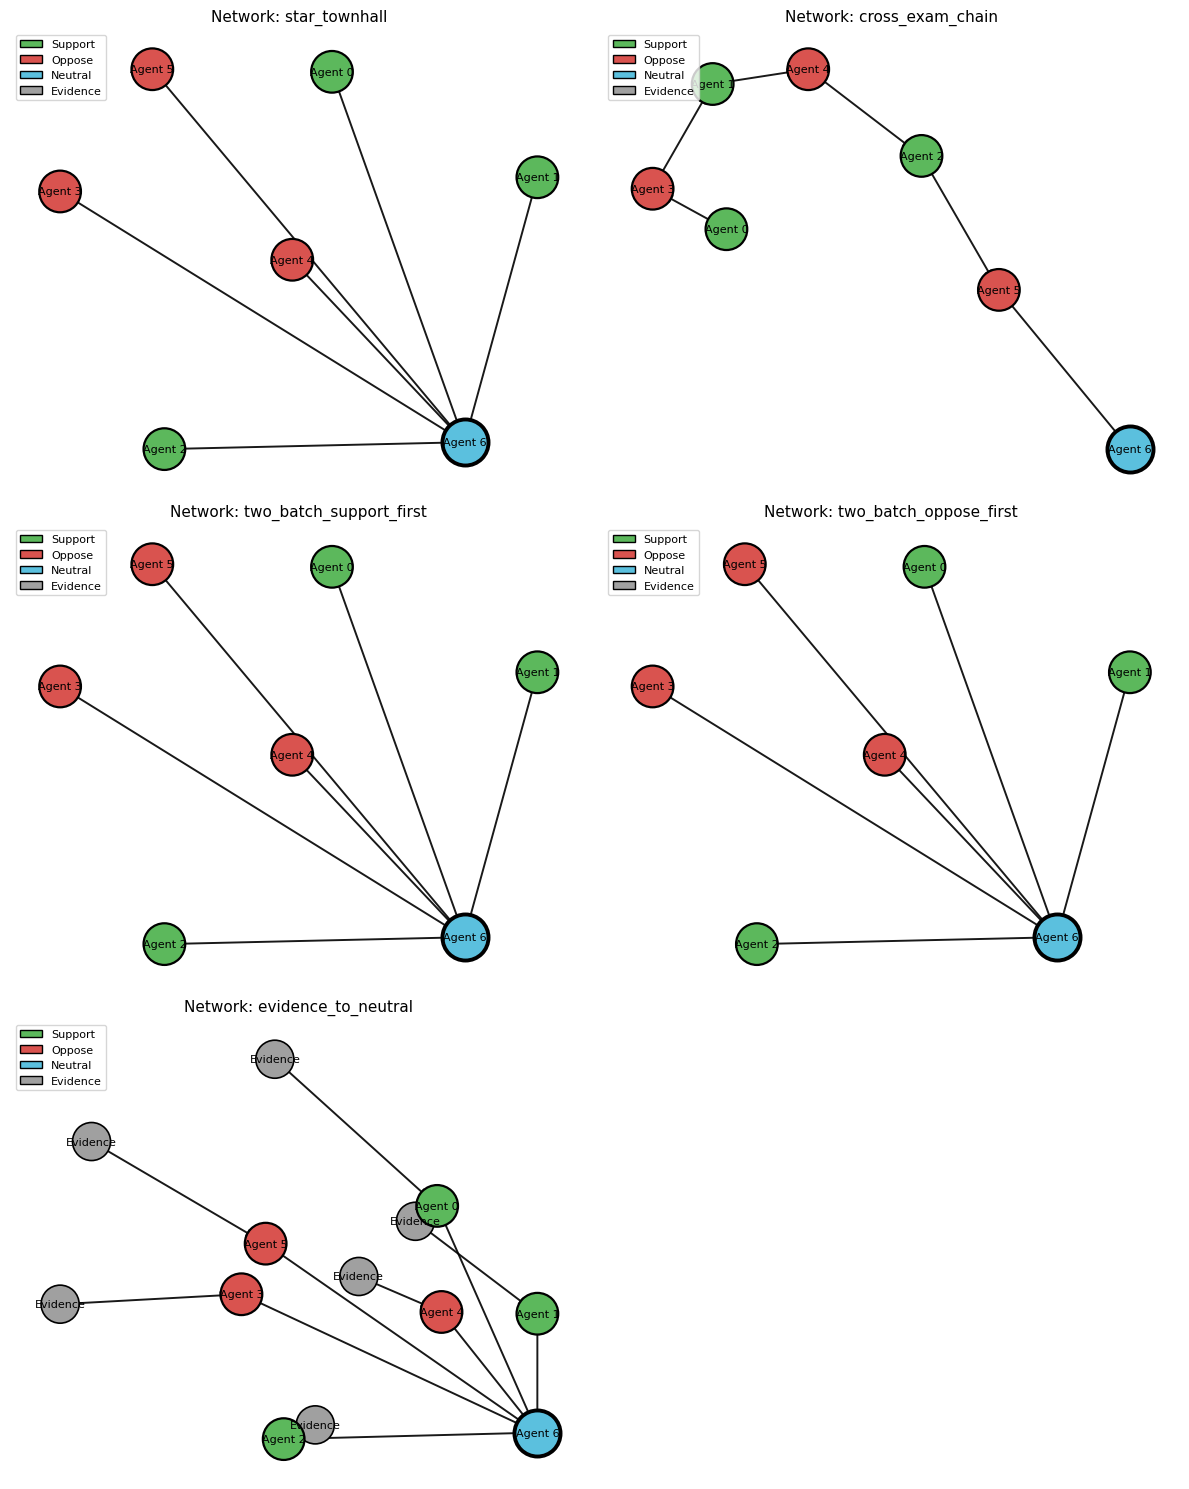

In [41]:
# === Visualization with Stakeholder Names ====================================
import math
from typing import Dict, Any, List, Tuple
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from plurals.agent import Agent

Edge = Tuple[int, int]

# Helper: stance inference (colors by stance)
def _infer_stance_indices(agents: List[Agent]) -> Dict[str, List[int]]:
    sup, opp, neu, evid = [], [], [], []
    for i, a in enumerate(agents):
        p = (getattr(a, "persona", "") or "").lower()
        if "support the measure" in p:
            sup.append(i)
        elif "oppose the measure" in p:
            opp.append(i)
        elif "neutral voter" in p:
            neu.append(i)
        elif "evidence node" in p:
            evid.append(i)
    return {"support": sup, "oppose": opp, "neutral": neu, "evidence": evid}

def _get_node_styles(agents: List[Agent]):
    idx = _infer_stance_indices(agents)
    colors, sizes, borders = [], [], []
    NEUTRAL_COLOR = "#5BC0DE"
    SUPPORT_COLOR = "#5CB85C"
    OPPOSE_COLOR  = "#D9534F"
    EVID_COLOR    = "#A0A0A0"

    for i, a in enumerate(agents):
        if i in idx["neutral"]:
            colors.append(NEUTRAL_COLOR); sizes.append(1100); borders.append(2.8)
        elif i in idx["support"]:
            colors.append(SUPPORT_COLOR);  sizes.append(900);  borders.append(1.6)
        elif i in idx["oppose"]:
            colors.append(OPPOSE_COLOR);   sizes.append(900);  borders.append(1.6)
        elif i in idx["evidence"]:
            colors.append(EVID_COLOR);     sizes.append(750);  borders.append(1.2)
        else:
            colors.append("#BBBBBB");      sizes.append(800);  borders.append(1.2)
    return colors, sizes, borders

def visualize_network(name: str, agents: List[Agent], edges: List[Edge], meta: Dict[str, Any] | None = None, ax=None, seed: int = 42):
    """
    Draw a single directed network with colors by stance and agent names as labels.
    """
    G = nx.DiGraph()
    G.add_nodes_from(range(len(agents)))
    G.add_edges_from(edges)

    colors, sizes, borders = _get_node_styles(agents)
    # Label each node with agent.name (fallback: "Agent i")
    labels = {i: getattr(a, "name", None) or f"Agent {i}" for i, a in enumerate(agents)}

    pos = nx.spring_layout(G, seed=seed)

    created_fig = False
    if ax is None:
        created_fig = True
        fig, ax = plt.subplots(figsize=(6, 5))

    # Draw nodes by border groups
    unique_border_levels = sorted(set(borders))
    for lw in unique_border_levels:
        idxs = [i for i, b in enumerate(borders) if b == lw]
        nx.draw_networkx_nodes(
            G, pos, nodelist=idxs,
            node_size=[sizes[i] for i in idxs],
            node_color=[colors[i] for i in idxs],
            linewidths=lw, edgecolors="black", ax=ax
        )

    nx.draw_networkx_edges(G, pos, arrows=True, arrowsize=12, width=1.4, alpha=0.9, ax=ax)
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=8, ax=ax)

    ax.set_title(f"Network: {name}", fontsize=11)
    ax.axis("off")

    legend_elems = [
        Patch(facecolor="#5CB85C", edgecolor="black", label="Support"),
        Patch(facecolor="#D9534F", edgecolor="black", label="Oppose"),
        Patch(facecolor="#5BC0DE", edgecolor="black", label="Neutral"),
        Patch(facecolor="#A0A0A0", edgecolor="black", label="Evidence"),
    ]
    ax.legend(handles=legend_elems, loc="upper left", fontsize=8, frameon=True)

    if created_fig:
        plt.tight_layout()
        plt.show()

def visualize_networks_grid(networks: Dict[str, Dict[str, Any]], seed: int = 42, cols: int = 2):
    """
    Draw all networks in a grid. Each node is labeled by agent.name.
    Expects the registry format:
      networks[name] = {"agents": [...], "edges": [...], "meta": {...}}
    """
    names = list(networks.keys())
    n = len(names)
    rows = math.ceil(n / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 5*rows))
    if rows == 1 and cols == 1:
        axes = [[axes]]
    elif rows == 1:
        axes = [axes]
    elif cols == 1:
        axes = [[ax] for ax in axes]

    for idx, name in enumerate(names):
        r, c = divmod(idx, cols)
        spec = networks[name]
        visualize_network(
            name=name,
            agents=spec["agents"],
            edges=spec["edges"],
            meta=spec.get("meta", {}),
            ax=axes[r][c],
            seed=seed
        )

    for k in range(n, rows*cols):
        r, c = divmod(k, cols)
        axes[r][c].axis("off")

    plt.tight_layout()
    plt.show()

# --- Example (after you have registry `nets`) --------------------------------
# nets = build_five_network_registry(agents)
visualize_networks_grid(nets, seed=42, cols=2)

In [42]:
# === Run deliberations on all networks (use after summary/agents/networks) ===
import re
from typing import Dict, Any, List
from plurals.deliberation import Graph, Moderator

# --- Helpers for neutral shift parsing ---------------------------------------
_NEUTRAL_REGEX = re.compile(
    r"NEUTRAL_SHIFT:\s*pre=(-?\d+)\s+post=(-?\d+)\s+conf=(\d{1,3})\s+driver=(Support|Oppose)\s+counter=(Support|Oppose)",
    re.IGNORECASE,
)

def _parse_neutral_shift(text: str) -> Dict[str, Any]:
    m = _NEUTRAL_REGEX.search(text or "")
    if not m:
        return {}
    pre, post, conf, driver, counter = m.groups()
    pre, post, conf = int(pre), int(post), int(conf)
    delta = post - pre
    direction = "Toward YES" if delta > 0 else "Toward NO" if delta < 0 else "Unmoved"
    return {
        "pre": pre, "post": post, "delta": delta,
        "direction": direction, "confidence": conf,
        "top_driver": driver, "counterweight": counter
    }

# --- Runner for one network --------------------------------------------------
def run_one_network(name: str, spec: Dict[str, Any], ballot_summary: str, ballot_text: str, model="gpt-4o") -> Dict[str, Any]:
    combo = (
        "Respond in ≤200 words. "
        "Cite one prior point by name, state your stance, rebut one counterpoint, "
        "and add one specific consideration."
    )

    # attach to all agents
    for a in spec["agents"]:
        a.combination_instructions = combo

    moderator = Moderator(
        persona="You are a neutral analyst summarizing a multi-stakeholder conversation.",
        model=model,
        combination_instructions=(
            "Synthesize the debate: supporters vs opponents, responses, strongest points, and any common ground.\n"
            "Then OUTPUT EXACTLY ONE FINAL LINE in this format (no extra text after it):\n"
            "NEUTRAL_SHIFT: pre=<-3..3> post=<-3..3> conf=<0..100> driver=<Support|Oppose> counter=<Support|Oppose>\n"
        ),
    )

    task = (
        "Provide your stakeholder perspective based on the summary and prior messages.\n"
        f"BALLOT SUMMARY:\n{ballot_summary}\n\n"
        f"FULL BALLOT (excerpt):\n{ballot_text[:2000]}..."
    )

    graph = Graph(
        agents=spec["agents"],
        edges=spec["edges"],
        moderator=moderator,
        task=task,
        combination_instructions=combo
    )
    graph.process()

    mod_text = getattr(graph, "final_response", "") or ""
    neutral_shift = _parse_neutral_shift(mod_text)

    return {"network": name, "neutral_shift": neutral_shift, "moderator_summary": mod_text}

# --- Runner for all networks -------------------------------------------------
def run_all_networks(networks: Dict[str, Dict[str, Any]], ballot_summary: str, ballot_text: str, model="gpt-4o") -> List[Dict[str, Any]]:
    results = []
    for name, spec in networks.items():
        print(f"Running deliberation on: {name}")
        r = run_one_network(name, spec, ballot_summary, ballot_text, model=model)
        print(f" → Neutral shift: {r['neutral_shift']}\n")
        results.append(r)

    print("\n=== Neutral Shift Summary ===")
    for r in results:
        ns = r["neutral_shift"] or {}
        print(f"{r['network']:<25} Δ={ns.get('delta','?')} | dir={ns.get('direction','?')} | conf={ns.get('confidence','?')}")
    return results

from typing import Dict, Any, List

def _print_divider(char="=", width=50):
    print("\n" + char*width)

def _print_section(title: str):
    print(f"\n{title}")
    print("-"*30)

def _fmt_shift(ns: Dict[str, Any]) -> str:
    if not ns:
        return "Δ=? | dir=? | conf=?"
    return f"Δ={ns.get('delta','?')} | dir={ns.get('direction','?')} | conf={ns.get('confidence','?')}"

def render_detailed_report(ballot_summary: str, stakeholders: Dict[str, List[str]], results: List[Dict[str, Any]]):
    _print_divider("=")
    print("BALLOT MEASURE ANALYSIS RESULTS")
    _print_divider("=")

    # 1) Summary
    _print_section("1. PLAIN LANGUAGE SUMMARY:")
    print(ballot_summary.strip())

    # 2) Stakeholders
    _print_section("2. IDENTIFIED STAKEHOLDERS:")
    print("Primary Supporters:")
    for g in stakeholders.get("primary_supporters", []):
        print(f"  - {g}")
    print("\nPrimary Opponents:")
    for g in stakeholders.get("primary_opponents", []):
        print(f"  - {g}")

    # 3) Per-network syntheses
    _print_section(f"3. STAKEHOLDER DELIBERATIONS ({len(results)} networks):")

    # Summary table-like header
    print("=== Neutral Shift Summary ===")
    for r in results:
        ns = r.get("neutral_shift", {}) or {}
        print(f"{r.get('network','?'):<25} {_fmt_shift(ns)}")

    # Detailed per-network write-ups
    for r in results:
        _print_divider("-")
        net = r.get("network", "?")
        ns  = r.get("neutral_shift", {}) or {}
        mod = (r.get("moderator_summary", "") or "").strip()

        print(f"\n### Network: {net}")
        print(f"Neutral shift → {_fmt_shift(ns)}")
        if mod:
            print("\nModerator Synthesis:")
            print(mod)
        else:
            print("\n(No moderator synthesis available for this run.)")

In [43]:
results = run_all_networks(nets, ballot_summary=summary_text, ballot_text=ballot, model="gpt-4o")
render_detailed_report(summary_text, stakeholders, results)

Running deliberation on: star_townhall
 → Neutral shift: {'pre': 0, 'post': 0, 'delta': 0, 'direction': 'Unmoved', 'confidence': 85, 'top_driver': 'Support', 'counterweight': 'Oppose'}

Running deliberation on: cross_exam_chain
 → Neutral shift: {'pre': 0, 'post': 0, 'delta': 0, 'direction': 'Unmoved', 'confidence': 75, 'top_driver': 'Support', 'counterweight': 'Oppose'}

Running deliberation on: two_batch_support_first
 → Neutral shift: {'pre': 0, 'post': 0, 'delta': 0, 'direction': 'Unmoved', 'confidence': 80, 'top_driver': 'Support', 'counterweight': 'Oppose'}

Running deliberation on: two_batch_oppose_first
 → Neutral shift: {'pre': 0, 'post': 1, 'delta': 1, 'direction': 'Toward YES', 'confidence': 85, 'top_driver': 'Support', 'counterweight': 'Oppose'}

Running deliberation on: evidence_to_neutral
 → Neutral shift: {'pre': 0, 'post': 0, 'delta': 0, 'direction': 'Unmoved', 'confidence': 70, 'top_driver': 'Support', 'counterweight': 'Oppose'}


=== Neutral Shift Summary ===
star_tow